
# Learning Shapelets

This example illustrates how the "Learning Shapelets" method can quickly
find a set of shapelets that results in excellent predictive performance
when used for a shapelet transform.

More information on the method can be found at:
http://fs.ismll.de/publicspace/LearningShapelets/.


In [1]:
# Author: Romain Tavenard
# License: BSD 3 clause
%pip install tslearn

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt


from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.4 MB/s eta 0:00:00


In [2]:
# Data preparation and parameters learning

# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))



# Set the number of shapelets per size as done in the original Graboka paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)



# using format() method and referring a position of the object
print('n_ts: {0}, ts_sz: {1}, classes: {2}, shapelet_size={3}'.format(n_ts, ts_sz,n_classes,shapelet_sizes))





n_ts: 100, ts_sz: 275, classes: 4, shapelet_size={27: 4}


/usr/local/lib/python3.10/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Correct classification rate: 1.0


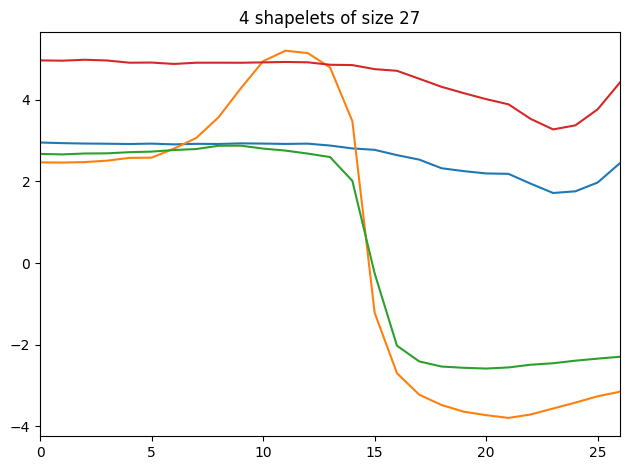

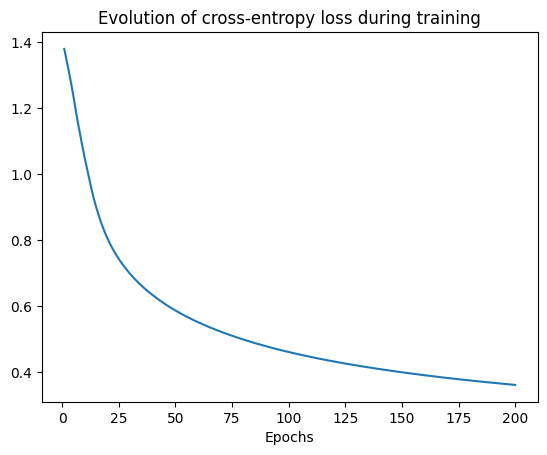

In [3]:
# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)
shp_clf.fit(X_train, y_train)

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))



# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

# In the following part test shapelet learning classification in several dataset, recording and assessing the performance.

Documentation of TS UCR datasets here : https://tslearn.readthedocs.io/en/stable/gen_modules/datasets/tslearn.datasets.UCR_UEA_datasets.html#tslearn.datasets.UCR_UEA_datasets

List of the dataset
https://www.timeseriesclassification.com/dataset.php

In [4]:
from tslearn.datasets import UCR_UEA_datasets
print(UCR_UEA_datasets().list_datasets())


# example of dataset loading
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("ShapeletSim")

# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)


#...continue working here



['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']
n_ts: 20, ts_sz: 500, classes: 2, shapelet_size={50: 3}
